Data:
1. data.txt: 4601個資料點(rows)，各有58個維度(columns)
2. c1.txt: 隨機選的10個資料點，各58個維度
3. c2.txt: 距離最遠10個資料點，各58個維度

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark import SparkConf, SparkContext

In [4]:
conf = SparkConf().setMaster("local[*]").setAppName("Kmeans")
sc = SparkContext(conf=conf)

In [8]:
pre_data = sc.textFile("data.txt")

In [9]:
pre_data.take(1)

['0 0.64 0.64 0 0.32 0 0 0 0 0 0 0.64 0 0 0 0.32 0 1.29 1.93 0 0.96 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.778 0 0 3.756 61 278 1']

In [14]:
data = sc.textFile("data.txt").map(lambda line: line.split("\t"))

In [15]:
data.take(1)

[['0 0.64 0.64 0 0.32 0 0 0 0 0 0 0.64 0 0 0 0.32 0 1.29 1.93 0 0.96 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.778 0 0 3.756 61 278 1']]

In [20]:
data1 = sc.parallelize(list(enumerate(data.collect()))).map(lambda x: (x[0],x[1][0].split(" ")))

In [21]:
data1.take(1)

[(0,
  ['0',
   '0.64',
   '0.64',
   '0',
   '0.32',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0.64',
   '0',
   '0',
   '0',
   '0.32',
   '0',
   '1.29',
   '1.93',
   '0',
   '0.96',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0.778',
   '0',
   '0',
   '3.756',
   '61',
   '278',
   '1'])]

In [22]:
c1 = sc.textFile("c1.txt").map(lambda line: line.split("\t"))

In [24]:
c11 = sc.parallelize(list(enumerate(c1.collect()))).map(lambda x: (x[0],x[1][0].split(" ")))

In [25]:
c2 = sc.textFile("c2.txt").map(lambda line: line.split("\t"))

In [26]:
c21 = sc.parallelize(list(enumerate(c2.collect()))).map(lambda x: (x[0],x[1][0].split(" ")))

In [27]:
dict_data = {}
dict_data.update(data1.collect())

In [28]:
dict_c1 = {}
dict_c1.update(c11.collect())

In [29]:
dict_c2 = {}
dict_c2.update(c21.collect())

# 利用Kmeans演算法做分群

## 1. 以Euclidean Distance運算距離
* 1.1 以C1作為中心點
* 1.2 以C2作為中心點

## 2. 以Manhattan Distance運算距離
* 2.1 以C1作為中心點
* 2.2 以C2作為中心點

## 3. 繪圖:以cost function比較performance
* 同以Euclidean Distance為運算依據，以C1與C2作為初始中心點的比較
* 同以Manhattan Distance為運算依據，以C1與C2作為初始中心點的比較

#     

# 1. 以Euclidean Distance運算距離
## 1.1 以C1作為中心點

### (1) 算出對每個center的距離，並以最小距離的center作為所屬center (mapper1)

In [32]:
len(dict_c1)

10

In [33]:
def mapper1(x):
    all_dis = []
    #有幾個center就要跑幾次，center的數量=dict_c1的長度=10
    for i in range(len(dict_c1)):
        distance = 0
        #每個dimension和center對應的點做比較
        for c in range(len(dict_c1[0])):
            #Euclidean的公式
            distance += (eval(x[1][c])-eval(dict_c1[i][c])) ** 2
        #將與這10個center的距離list起來
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1])) #後面那一項選list裡面distance最小的(i,distance)，意即被分配到的center

In [34]:
distributed_c1_m = data1.map(mapper1)

In [37]:
distributed_c1_m.take(15)
#第1個點被分配到center0，最小距離0
#第10個點被分配到center7，最小距離840.659724

[(0, (0, 0.0)),
 (1, (1, 0.0)),
 (2, (2, 0.0)),
 (3, (3, 0.0)),
 (4, (4, 0.0)),
 (5, (5, 0.0)),
 (6, (6, 0.0)),
 (7, (7, 0.0)),
 (8, (8, 0.0)),
 (9, (9, 0.0)),
 (10, (7, 840.659724)),
 (11, (3, 901.125645)),
 (12, (0, 289.141784)),
 (13, (7, 608.120325)),
 (14, (3, 489.09468100000004))]

### (2) 計算cost function
* 只需將所有distance相加就可得到cost_function

In [38]:
cost_function_c1_m = distributed_c1_m.map(lambda x: x[1]).values().sum()

In [44]:
#後續比較performance improvement時繪圖用
cost_list_c1_m = []
cost_list_c1_m.append(cost_function_c1_m)

In [45]:
#現在list中只有1個element，意即所有點到c1的最小距離加總
cost_list_c1_m

[623660345.3064113]

### (3) 算出新的center (mapper2)
+ distribute: return ("最近距離中心"的編號，座標編號)
+ cluster: groupbykey之後 return (中心編號，"被分類到此中心的所有座標"的編號)
+ mapper2: 對於每個中心，把"被分類到此中心的所有座標"取平均得到一個新的中心

In [47]:
distributed_c1_m.take(1)

[(0, (0, 0.0))]

In [46]:
distribute = distributed_c1_m.map(lambda x: (x[1][0],x[0]))

In [48]:
distribute.take(1)

[(0, 0)]

In [53]:
cluster = distribute.groupByKey().map(lambda x: (x[0],list(x[1])))

In [54]:
#center0裡包含哪些點
cluster.take(1)

[(0,
  [0,
   12,
   15,
   17,
   34,
   37,
   39,
   44,
   46,
   59,
   60,
   68,
   70,
   72,
   74,
   75,
   81,
   96,
   101,
   103,
   105,
   114,
   118,
   124,
   129,
   130,
   137,
   140,
   146,
   156,
   162,
   167,
   178,
   186,
   188,
   201,
   202,
   204,
   212,
   219,
   223,
   226,
   227,
   234,
   238,
   239,
   242,
   246,
   248,
   265,
   269,
   270,
   274,
   275,
   276,
   277,
   279,
   283,
   288,
   290,
   293,
   295,
   299,
   302,
   311,
   313,
   314,
   318,
   319,
   322,
   335,
   350,
   354,
   380,
   385,
   386,
   408,
   412,
   413,
   421,
   425,
   428,
   430,
   432,
   433,
   435,
   437,
   445,
   447,
   448,
   449,
   450,
   458,
   459,
   480,
   482,
   487,
   489,
   493,
   504,
   506,
   508,
   522,
   526,
   528,
   530,
   533,
   537,
   542,
   548,
   555,
   556,
   557,
   568,
   591,
   593,
   594,
   604,
   616,
   620,
   625,
   626,
   635,
   636,
   637,
   642,
   643

In [57]:
dict_data[4430]

['0',
 '0.31',
 '0.31',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0.31',
 '0',
 '0',
 '0.31',
 '0',
 '0',
 '0.63',
 '0',
 '0.31',
 '4.73',
 '0',
 '0.63',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0.63',
 '0',
 '0',
 '0',
 '0',
 '0.228',
 '0',
 '0.045',
 '0',
 '0.045',
 '8.117',
 '97',
 '414',
 '0']

In [58]:
def mapper2(x):
    list4 = []
    amount = len(x[1])
    #有幾個dimension=data0的長度=data1的長度
    for i in range(len(dict_data[0])):
        sum2 = 0
        #每一個被分配到此中心的data編號
        for c in x[1]:
            sum2 += eval(dict_data[c][i])
        #每次append新中心的1個dimension
        list4.append(sum2/amount)      
    return (x[0],list4) #list4最後會是新中心的座標

In [59]:
new_center = cluster.map(mapper2)

In [60]:
dict_c1.update(new_center.collect())

In [61]:
#centors的新座標
dict_c1

{0: [0.11368686868686871,
  0.13171717171717165,
  0.325959595959596,
  0.21760942760942759,
  0.40358585858585866,
  0.12148148148148143,
  0.19702020202020207,
  0.13813131313131316,
  0.14079124579124577,
  0.2882323232323232,
  0.0954377104377104,
  0.5731649831649828,
  0.11474747474747476,
  0.029528619528619533,
  0.04464646464646464,
  0.2894949494949498,
  0.27212121212121193,
  0.23375420875420888,
  1.7182659932659918,
  0.15373737373737373,
  0.9688383838383843,
  0.47745791245791247,
  0.1747306397306397,
  0.11134680134680132,
  0.49267676767676766,
  0.1827946127946128,
  0.08250841750841754,
  0.05552188552188553,
  0.03924242424242425,
  0.044831649831649834,
  0.038552188552188546,
  0.02048821548821549,
  0.05511784511784511,
  0.021397306397306397,
  0.05045454545454546,
  0.06893939393939393,
  0.14355218855218854,
  0.012693602693602696,
  0.03725589225589226,
  0.07390572390572389,
  0.020555555555555556,
  0.035336700336700326,
  0.03255892255892255,
  0.0254713

### (4) 重複運算出新中心19次 (mapper3)

In [62]:
def mapper3(x):
    all_dis = []
    for i in range(len(dict_c1)):
        distance = 0
        for c in range(len(dict_c1[0])):
            distance += (eval(x[1][c])-dict_c1[i][c]) ** 2
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [63]:
for i in range(19):
    data2 = data1.map(mapper3)
    
    #cost_function
    cost_function = data2.map(lambda x: x[1]).values().sum()
    cost_list1.append(cost_function)
    
    #new_center
    distribute = data2.map(lambda x: (x[1][0],x[0]))
    cluster = distribute.groupByKey()
    new_center = cluster.map(mapper2)
    dict_c1.update(new_center.collect())

In [64]:
cost_list1

[623660345.3064113,
 623660345.3064113,
 509862908.2975454,
 485480681.8720078,
 463997011.685013,
 460969266.5729963,
 460537847.98276776,
 460313099.6535457,
 460003523.88940746,
 459570539.3177351,
 459021103.3422907,
 458490656.191981,
 457944232.5879743,
 457558005.1986762,
 457290136.35230225,
 457050555.0595627,
 456892235.61535454,
 456703630.7370334,
 456404203.01897496,
 456177800.5419933,
 455986871.0273458]

### (5) 計算percentage_improvement
* 計算以初始中心為中心作為分群依據與重複19次運算之後的新中心作為分群依據的cost function差異

In [65]:
percentage_improvement_c1_e = abs(cost_list1[-1]-cost_list1[0])/cost_list1[0] 

In [66]:
percentage_improvement_c1_e

0.26885383292517284

In [67]:
list_data = list(new_center.collect())

In [70]:
list_data.sort()

## 1.2 以C2作為中心點
* (1) 算出對每個center的距離，並以最小距離的center作為所屬center (mapper1)
* (2) 計算cost function
* (3) 算出新的center (mapper2)
* (4) 重複運算出新中心19次 (mapper3)
* (5) 計算percentage_improvement

(1) 算出對每個center的距離，並以最小距離的center作為所屬center (mapper1)

In [229]:
def mapper1_1(x):
    all_dis = []
    for i in range(len(dict_c2)):
        distance = 0
        for c in range(len(dict_c2[0])):
            distance += (eval(x[1][c])-eval(dict_c2[i][c])) ** 2
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [230]:
data2_1 = data1.map(mapper1_1)

(2) 計算cost function

In [231]:
cost_function_1 = data2_1.map(lambda x: x[1]).values().sum()

In [232]:
cost_list1_1 = []

In [233]:
cost_list1_1.append(cost_function_1)

(3) 算出新的center (mapper2)

In [234]:
distribute_1 = data2_1.map(lambda x: (x[1][0],x[0]))

In [235]:
cluster_1 = distribute_1.groupByKey()

In [236]:
def mapper2_1(x):
    list4 = []
    amount = len(x[1])
    for i in range(len(dict_data[0])):
        sum2 = 0
        for c in x[1]:
            sum2 += eval(dict_data[c][i])
        list4.append(sum2/amount)      
    return (x[0],list4)

In [237]:
new_center_1 = cluster_1.map(mapper2_1)

In [238]:
dict_c2.update(new_center_1.collect())

(4) 重複運算出新中心19次 (mapper3)

In [239]:
def mapper3_1(x):
    all_dis = []
    for i in range(len(dict_c2)):
        distance = 0
        for c in range(len(dict_c2[0])):
            distance += (eval(x[1][c])-dict_c2[i][c]) ** 2
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [240]:
for i in range(19):
    data2_1 = data1.map(mapper3_1)
    
    #cost_function
    cost_function_1 = data2_1.map(lambda x: x[1]).values().sum()
    cost_list1_1.append(cost_function_1)
    
    #new_center
    distribute_1 = data2_1.map(lambda x: (x[1][0],x[0]))
    cluster_1 = distribute_1.groupByKey()
    new_center_1 = cluster_1.map(mapper2_1)
    dict_c2.update(new_center_1.collect())

(5) 計算percentage_improvement

In [241]:
percentage_improvement_c2_e = abs(cost_list1_1[-1]-cost_list1_1[0])/cost_list1_1[0] 

In [242]:
percentage_improvement_c2_e

0.79437750291599

#  

# 2. 以Manhattan Distance運算距離

## 2.1 以C1作為中心點
* (1) 算出對每個center的距離，並以最小距離的center作為所屬center (mapper1_2)
* (2) 計算cost function
* (3) 算出新的center (mapper2_2)
* (4) 重複運算出新中心19次 (mapper3_2)
* (5) 計算percentage_improvement

(1) 算出對每個center的距離，並以最小距離的center作為所屬center (mapper1_2)


In [248]:
dict_c1 = {}
dict_c1.update(c11.collect())

In [249]:
def mapper1_2(x):
    all_dis = []
    for i in range(len(dict_c1)):
        distance = 0
        for c in range(len(dict_c1[0])):
            distance += abs(eval(x[1][c])-eval(dict_c1[i][c]))
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [250]:
data2_2 = data1.map(mapper1_2)

(2) 計算cost function

In [251]:
cost_function_2 = data2_2.map(lambda x: x[1]).values().sum()

In [252]:
cost_list1_2 = []

In [253]:
cost_list1_2.append(cost_function_2)

(3) 算出新的center (mapper2_2)

In [254]:
distribute_2 = data2_2.map(lambda x: (x[1][0],x[0]))

In [255]:
cluster_2 = distribute_2.groupByKey()

In [256]:
def mapper2_2(x):
    list4 = []
    amount = len(x[1])
    for i in range(len(dict_data[0])):
        sum2 = 0
        for c in x[1]:
            sum2 += eval(dict_data[c][i])
        list4.append(sum2/amount)      
    return (x[0],list4)

In [257]:
new_center_2 = cluster_2.map(mapper2_2)

In [258]:
dict_c1.update(new_center_2.collect())

(4) 重複運算出新中心19次 (mapper3_2)

In [259]:
def mapper3_2(x):
    all_dis = []
    for i in range(len(dict_c1)):
        distance = 0
        for c in range(len(dict_c1[0])):
            distance += abs(eval(x[1][c])-dict_c1[i][c])
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [260]:
for i in range(19):
    data2_2 = data1.map(mapper3_2)
    
    #cost_function
    cost_function_2 = data2_2.map(lambda x: x[1]).values().sum()
    cost_list1_2.append(cost_function_2)
    
    #new_center
    distribute_2 = data2_2.map(lambda x: (x[1][0],x[0]))
    cluster_2 = distribute_2.groupByKey()
    new_center_2 = cluster_2.map(mapper2_2)
    dict_c1.update(new_center_2.collect())

(5) 計算percentage_improvement

In [261]:
percentage_improvement_c1_m = abs(cost_list1_2[-1]-cost_list1_2[0])/cost_list1_2[0] 

In [127]:
percentage_improvement_c1_m

0.18378954327236927

#  

## 2.1 以C1作為中心點
* (1) 算出對每個center的距離，並以最小距離的center作為所屬center (mapper1_3)
* (2) 計算cost function
* (3) 算出新的center (mapper2_3)
* (4) 重複運算出新中心19次 (mapper3_3)
* (5) 計算percentage_improvement

(1) 算出對每個center的距離，並以最小距離的center作為所屬center (mapper1_3)

In [267]:
dict_c2 = {}
dict_c2.update(c21.collect())

In [268]:
def mapper1_3(x):
    all_dis = []
    for i in range(len(dict_c2)):
        distance = 0
        for c in range(len(dict_c2[0])):
            distance += abs(eval(x[1][c])-eval(dict_c2[i][c]))
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [269]:
data2_3 = data1.map(mapper1_3)

(2) 計算cost function

In [270]:
cost_function_3 = data2_3.map(lambda x: x[1]).values().sum()

In [271]:
cost_list1_3 = []

In [272]:
cost_list1_3.append(cost_function_3)

(3) 算出新的center (mapper2_3)

In [273]:
distribute_3 = data2_3.map(lambda x: (x[1][0],x[0]))

In [274]:
cluster_3 = distribute_3.groupByKey()

In [275]:
def mapper2_3(x):
    list4 = []
    amount = len(x[1])
    for i in range(len(dict_data[0])):
        sum2 = 0
        for c in x[1]:
            sum2 += eval(dict_data[c][i])
        list4.append(sum2/amount)      
    return (x[0],list4)

In [276]:
new_center_3 = cluster_3.map(mapper2_3)

In [277]:
dict_c2.update(new_center_3.collect())

(4) 重複運算出新中心19次 (mapper3_3)

In [278]:
def mapper3_3(x):
    all_dis = []
    for i in range(len(dict_c2)):
        distance = 0
        for c in range(len(dict_c2[0])):
            distance += abs(eval(x[1][c])-dict_c2[i][c])
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [279]:
for i in range(19):
    data2_3 = data1.map(mapper3_3)
    
    #cost_function
    cost_function_3 = data2_3.map(lambda x: x[1]).values().sum()
    cost_list1_3.append(cost_function_3)
    
    #new_center
    distribute_3 = data2_3.map(lambda x: (x[1][0],x[0]))
    cluster_3 = distribute_3.groupByKey()
    new_center_3 = cluster_3.map(mapper2)
    dict_c2.update(new_center_3.collect())

(5) 計算percentage_improvement

In [280]:
percentage_improvement_c2_m = abs(cost_list1_3[-1]-cost_list1_3[0])/cost_list1_3[0] 

In [147]:
percentage_improvement_c2_m

0.5468569434813413

# 

# 3. 繪圖:以cost function比較performance

* (1) 同以Euclidean Distance為運算依據，以C1與C2作為初始中心點的比較
* (2) 同以Manhattan Distance為運算依據，以C1與C2作為初始中心點的比較

In [74]:
import matplotlib.pyplot as plt

In [162]:
plt.figure(figsize=(15,10),dpi=100)

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [163]:
iteration = [i for i in range(1,21)]

(1) 同以Euclidean Distance為運算依據，以C1與C2作為初始中心點的比較

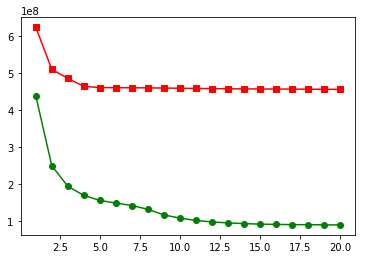

In [165]:
plt.plot(iteration,cost_list1,'s-',color = 'r', label="c1")
plt.plot(iteration,cost_list1_1,'o-',color = 'g', label="c2")

In [75]:
plt.figure(figsize=(15,10),dpi=100)

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

(2) 同以Manhattan Distance為運算依據，以C1與C2作為初始中心點的比較

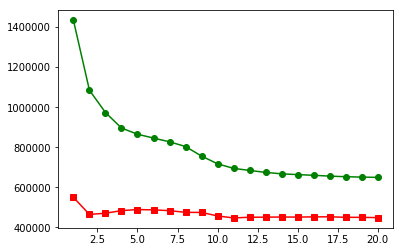

In [171]:
plt.plot(iteration,cost_list1_2,'s-',color = 'r', label="c1")
plt.plot(iteration,cost_list1_3,'o-',color = 'g', label="c2")